# 0- Updating and Importing the Needed Packages

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.WARNING)
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import skew, kurtosis, chi2_contingency, boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import LocalOutlierFactor
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,  roc_auc_score, roc_curve, precision_recall_curve, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from pytorch_tabnet.tab_model import TabNetClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.base import BaseEstimator, ClassifierMixin
from math import pi
import torch

# 1- Loading the Data and Early Data Inspection

In [2]:
# Load the dataset
data = pd.read_csv('1-8_4.csv')
data = data.drop(columns=['id'])

In [3]:
data.shape

(100000, 21)

# 3- Data Preprocessing

### 3-1 Manage Duplicates

In [4]:
# Check for duplicate rows in the dataset
duplicates = data.duplicated()

# Count the total number of duplicate rows
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicate rows and display a message
if num_duplicates > 0:
    data = data.drop_duplicates()
    print("Duplicates dropped.")
else:
    print("No duplicate rows found.")


Number of duplicate rows: 4
Duplicates dropped.


### 3-2 Manage Missing Values

In [5]:
# Calculate the portion of missing values for each column
missing_portion = data.isnull().mean()
print(missing_portion)

gender                          0.00000
age                             0.00125
tenure_days                     0.00000
handset_technology              0.00000
voice_payg_onnet_rev            0.00021
voice_pkg_onnet_rev             0.00021
voice_payg_offnet_rev           0.00021
voice_payg_international_rev    0.00021
data_pkg_rev                    0.00021
data_payg_rev                   0.00021
sms_onnet_rev                   0.00021
sms_other_rev                   0.00021
voice_payg_onnet_min            0.00580
voice_pkg_min                   0.00580
voice_offnet_min                0.00580
voice_international_min         0.00580
data_pkg_mb                     0.00580
data_payg_mb                    0.00580
sms_onnet_cnt                   0.00580
sms_other_cnt                   0.00580
churn_status                    0.00000
dtype: float64


In [6]:
data.dropna(inplace=True)

In [7]:
data.shape

(99291, 21)

### 3-3 Manage Noises

In [8]:
# Sample DataFrame with numeric and non-numeric columns
# data = pd.DataFrame(...)  # Replace with your actual data

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Filter out rows that have any negative values in numeric columns
data = data[(numeric_data >= 0).all(axis=1)]

print(data.shape)

(99277, 21)


### 3-4 Manage High Skew Features

In [9]:
# box-cox

# Select only numeric features
numeric_features = data.select_dtypes(include=['number'])

# Calculate skewness for numeric features
skewness = numeric_features.skew()

# Identify highly skewed numeric features (e.g., skewness > 1)
high_skew_features = skewness[skewness > 1].index.tolist()

# Apply Box-Cox transformation to only these features
lambda_values = {}
for feature in high_skew_features:
    # Shift to positive if necessary
    shift_value = abs(numeric_features[feature].min()) + 1 if (numeric_features[feature] <= 0).any() else 0
    numeric_features[feature] = numeric_features[feature] + shift_value

    # Apply Box-Cox transformation
    numeric_features[feature], fitted_lambda = boxcox(numeric_features[feature])
    lambda_values[feature] = {
        'lambda': fitted_lambda,
        'shift': shift_value
    }

# Create a summary of the transformations
lambda_df = pd.DataFrame(lambda_values).T
lambda_df.columns = ['Optimal Lambda', 'Shift Applied']

# Update the original dataset with the transformed numeric features
data.update(numeric_features)

# Display the Box-Cox transformation summary
print("Box-Cox Transformation Summary:")
print(lambda_df)


Box-Cox Transformation Summary:
                              Optimal Lambda  Shift Applied
voice_payg_onnet_rev                0.193192            1.0
voice_pkg_onnet_rev                -0.250460            1.0
voice_payg_offnet_rev               0.152535            1.0
voice_payg_international_rev       -1.102610            1.0
data_pkg_rev                        0.020125            1.0
data_payg_rev                      -0.011837            1.0
sms_onnet_rev                       0.108627            1.0
sms_other_rev                       0.056386            1.0
voice_payg_onnet_min                0.148251            1.0
voice_pkg_min                      -0.343780            1.0
voice_offnet_min                    0.040193            1.0
voice_international_min            -8.044406            1.0
data_pkg_mb                         0.012270            1.0
data_payg_mb                       -0.125295            1.0
sms_onnet_cnt                      -0.009933            1.0
sms_othe

### 3-5 Outlier detection

In [10]:
# Local Outlier Factor (LOF)

# copy data to data_lof
data_lof = data

from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Assuming your dataset is stored in a DataFrame called data
# The features you want to apply LOF to
features = ['age', 'tenure_days', 'voice_pkg_onnet_rev','voice_payg_international_rev', 'data_pkg_rev', 'data_payg_rev', 
    'sms_other_rev', 'voice_payg_onnet_min', 'voice_offnet_min', 
    'voice_international_min', 'data_pkg_mb', 'data_payg_mb', 'sms_onnet_cnt', 'sms_other_cnt']

# Initialize the Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # You can adjust contamination based on your data

# Fit the model and predict outliers (-1 indicates an outlier, 1 indicates inlier)
data_lof['lof_prediction'] = lof.fit_predict(data_lof[features])

# Filter out outliers (only keep rows that are not outliers)
data_clean_lof = data_lof[data_lof['lof_prediction'] == 1].copy()

# Optionally, drop the 'lof_prediction' column if no longer needed
data_clean_lof.drop(columns=['lof_prediction'], inplace=True)


In [11]:
data_clean_lof.shape

(94313, 21)

# 4- Feature Selection

#####  Filter-Based Feature Selection

In [12]:
# Remove Specified Features from the Data

# List of features to remove
features_to_remove = ['voice_payg_international_rev', 'voice_international_min']

# Drop these features from the dataset
data_clean_lof = data_clean_lof.drop(columns=features_to_remove)


In [13]:
data_clean_lof.shape

(94313, 19)

In [14]:
data_clean_lof.head()

,gender,age,tenure_days,handset_technology,voice_payg_onnet_rev,voice_pkg_onnet_rev,voice_payg_offnet_rev,data_pkg_rev,data_payg_rev,sms_onnet_rev,sms_other_rev,voice_payg_onnet_min,voice_pkg_min,voice_offnet_min,data_pkg_mb,data_payg_mb,sms_onnet_cnt,sms_other_cnt,churn_status
0,F,64.0,1500,4G,51.165658,0.000000,28.959734,15.269246,9.692191,22.716089,13.479425,8.454236,0.749802,4.580528,10.605876,3.034532,6.252590,3.74353,0
1,M,58.0,1209,2G,7.399802,0.000000,0.000000,0.000000,11.206184,13.757406,0.000000,0.095987,0.000000,0.000000,0.000000,3.881996,3.406757,0.00000,1
2,F,46.0,3177,4G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0
3,M,42.0,3160,4G,28.683506,3.862694,19.968305,18.555393,0.000000,13.182966,0.000000,13.340366,2.676351,2.489900,12.977938,0.000000,3.044069,0.00000,0
4,M,45.0,981,4G,42.439385,0.000000,21.341024,0.000000,0.000000,0.000000,0.000000,6.612902,0.000000,2.826985,0.000000,0.000000,0.000000,0.00000,1


# 5- Feature engineering

### 5-1 Creating New Features

In [15]:
X = data_clean_lof.drop(columns=['churn_status'])
y = data_clean_lof['churn_status']

In [16]:
# Derived Feature: Tenure per Year of Age

# Derived Feature : Tenure per Year of Age
X['tenure_per_year_of_age'] = ((X['tenure_days'] / 365) / X['age'])

# Drop the original columns
X = X.drop(columns=['age', 'tenure_days'])

In [17]:
X.shape

(94313, 17)

In [18]:
X.head()

,gender,handset_technology,voice_payg_onnet_rev,voice_pkg_onnet_rev,voice_payg_offnet_rev,data_pkg_rev,data_payg_rev,sms_onnet_rev,sms_other_rev,voice_payg_onnet_min,voice_pkg_min,voice_offnet_min,data_pkg_mb,data_payg_mb,sms_onnet_cnt,sms_other_cnt,tenure_per_year_of_age
0,F,4G,51.165658,0.000000,28.959734,15.269246,9.692191,22.716089,13.479425,8.454236,0.749802,4.580528,10.605876,3.034532,6.252590,3.74353,0.064212
1,M,2G,7.399802,0.000000,0.000000,0.000000,11.206184,13.757406,0.000000,0.095987,0.000000,0.000000,0.000000,3.881996,3.406757,0.00000,0.057109
2,F,4G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.189220
3,M,4G,28.683506,3.862694,19.968305,18.555393,0.000000,13.182966,0.000000,13.340366,2.676351,2.489900,12.977938,0.000000,3.044069,0.00000,0.206132
4,M,4G,42.439385,0.000000,21.341024,0.000000,0.000000,0.000000,0.000000,6.612902,0.000000,2.826985,0.000000,0.000000,0.000000,0.00000,0.059726


### 5-2 Encoding Categorical Features

In [19]:
X = pd.get_dummies(X, columns=['gender'], drop_first=True)
X = pd.get_dummies(X, columns=['handset_technology'], drop_first=True)

X['gender_M'] = X['gender_M'].astype(int)
X['handset_technology_3G'] = X['handset_technology_3G'].astype(int)
X['handset_technology_4G'] = X['handset_technology_4G'].astype(int)
X['handset_technology_5G'] = X['handset_technology_5G'].astype(int)

In [20]:
X.shape

(94313, 19)

In [21]:
X.head()

,voice_payg_onnet_rev,voice_pkg_onnet_rev,voice_payg_offnet_rev,data_pkg_rev,data_payg_rev,sms_onnet_rev,sms_other_rev,voice_payg_onnet_min,voice_pkg_min,voice_offnet_min,data_pkg_mb,data_payg_mb,sms_onnet_cnt,sms_other_cnt,tenure_per_year_of_age,gender_M,handset_technology_3G,handset_technology_4G,handset_technology_5G
0,51.165658,0.000000,28.959734,15.269246,9.692191,22.716089,13.479425,8.454236,0.749802,4.580528,10.605876,3.034532,6.252590,3.74353,0.064212,0,0,1,0
1,7.399802,0.000000,0.000000,0.000000,11.206184,13.757406,0.000000,0.095987,0.000000,0.000000,0.000000,3.881996,3.406757,0.00000,0.057109,1,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.189220,0,0,1,0
3,28.683506,3.862694,19.968305,18.555393,0.000000,13.182966,0.000000,13.340366,2.676351,2.489900,12.977938,0.000000,3.044069,0.00000,0.206132,1,0,1,0
4,42.439385,0.000000,21.341024,0.000000,0.000000,0.000000,0.000000,6.612902,0.000000,2.826985,0.000000,0.000000,0.000000,0.00000,0.059726,1,0,1,0


# 6-1 Data Splitting (into Train, Validation and Test)

In [23]:
# First, split the data into train + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the train + validation set into separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

# Print the shapes of the resulting datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (66018, 19) (66018,)
Validation set: (9432, 19) (9432,)
Test set: (18863, 19) (18863,)


# 6-2 Feature Scaling

most features have non-normal distribution. Thus, it may be more sensible to use data normalization rather than data standardization when rescaling the features.

In [22]:
# Min-Max Normalization

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

# Print the shapes of the resulting datasets
print("Training set:", X_train_scaled.shape, y_train.shape)
print("Validation set:", X_val_scaled.shape, y_val.shape)
print("Test set:", X_test_scaled.shape, y_test.shape)

# 7- Model Training and Hyperparameter Tunning

### 7-1 Logistic Regression (LR)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}


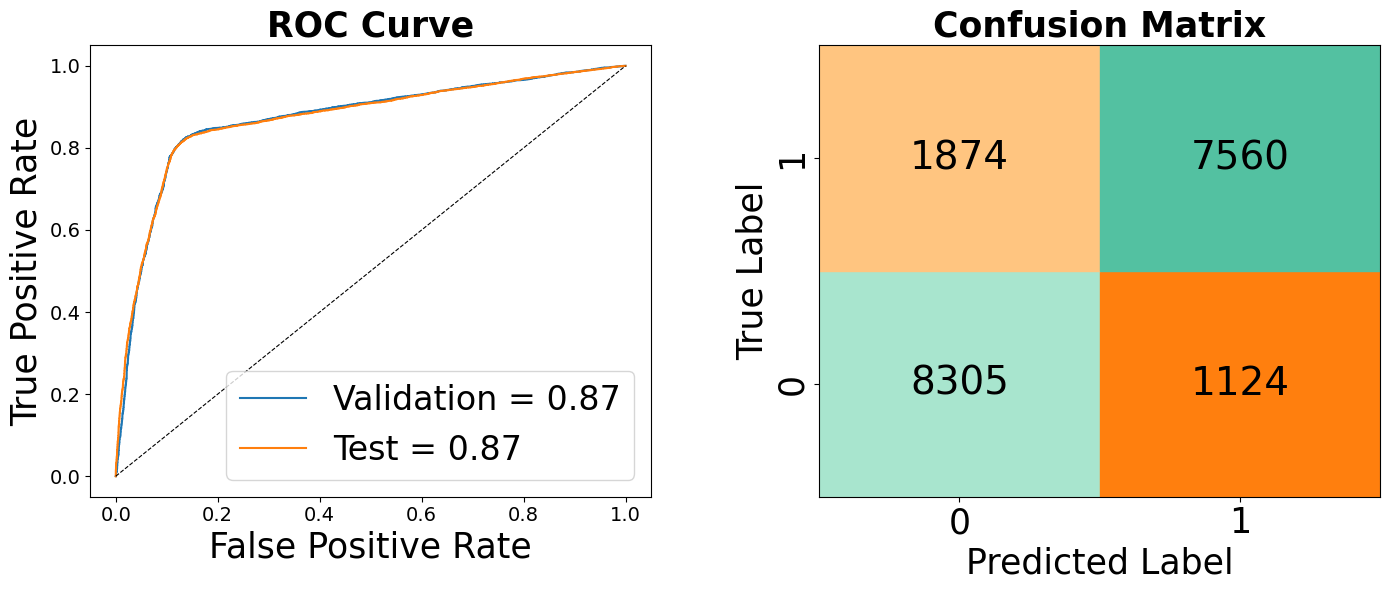


Validation Metrics:
Accuracy: 0.84, Precision: 0.87, Recall: 0.80, F1: 0.83, AUC: 0.87

Test Metrics:
Accuracy: 0.84, Precision: 0.87, Recall: 0.80, F1: 0.83, AUC: 0.87


In [24]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'C': [0.01],              # Regularization strength
    'penalty': ['l1'],  # Regularization types
    'solver': ['liblinear'],  # Compatible solvers
    'tol': [1e-3],                 # Tolerance for stopping criteria
}
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best Logistic Regression model
best_logreg = grid_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_logreg.predict(X_val)
y_val_proba = best_logreg.predict_proba(X_val)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

# Evaluate on the Test Set
y_test_pred = best_logreg.predict(X_test)
y_test_proba = best_logreg.predict_proba(X_test)[:, 1]

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve for Validation and Test Sets
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


### 7-3 Decision Tree (DT)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}


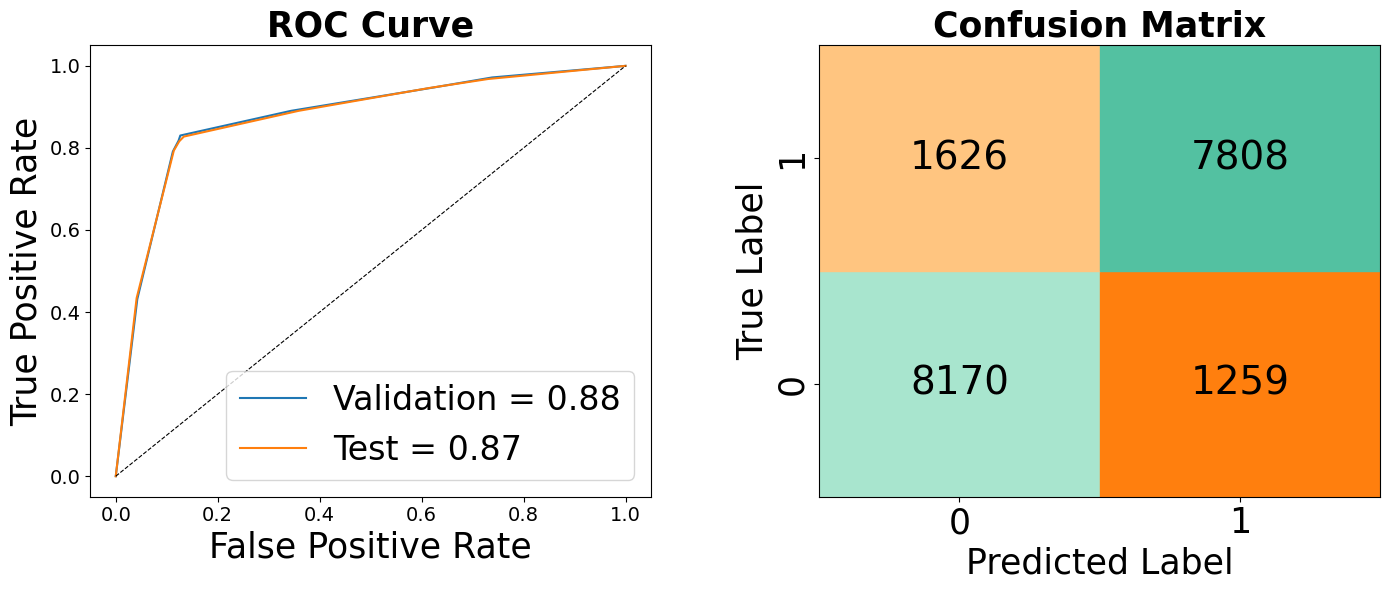


Validation Metrics:
Accuracy: 0.85, Precision: 0.87, Recall: 0.83, F1: 0.85, AUC: 0.88

Test Metrics:
Accuracy: 0.85, Precision: 0.86, Recall: 0.83, F1: 0.84, AUC: 0.87


In [25]:
# Initialize the Decision Tree model
dtree = DecisionTreeClassifier(random_state=42)

# Enhanced parameter grid for tuning
param_grid = {
    'max_depth': [3],         # Depth of the tree
    'min_samples_split': [2],      # Minimum samples to split a node
    'min_samples_leaf': [5],        # Minimum samples at a leaf node
    'criterion': ['gini'],         # Splitting criteria
    'splitter': ['best'],           # Splitting strategy
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best Decision Tree model
best_dtree = grid_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_dtree.predict(X_val)
y_val_proba = best_dtree.predict_proba(X_val)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

# Evaluate on the Test Set
y_test_pred = best_dtree.predict(X_test)
y_test_proba = best_dtree.predict_proba(X_test)[:, 1]

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve for Validation and Test Sets
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


### 7-3 Random Forest (RF)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


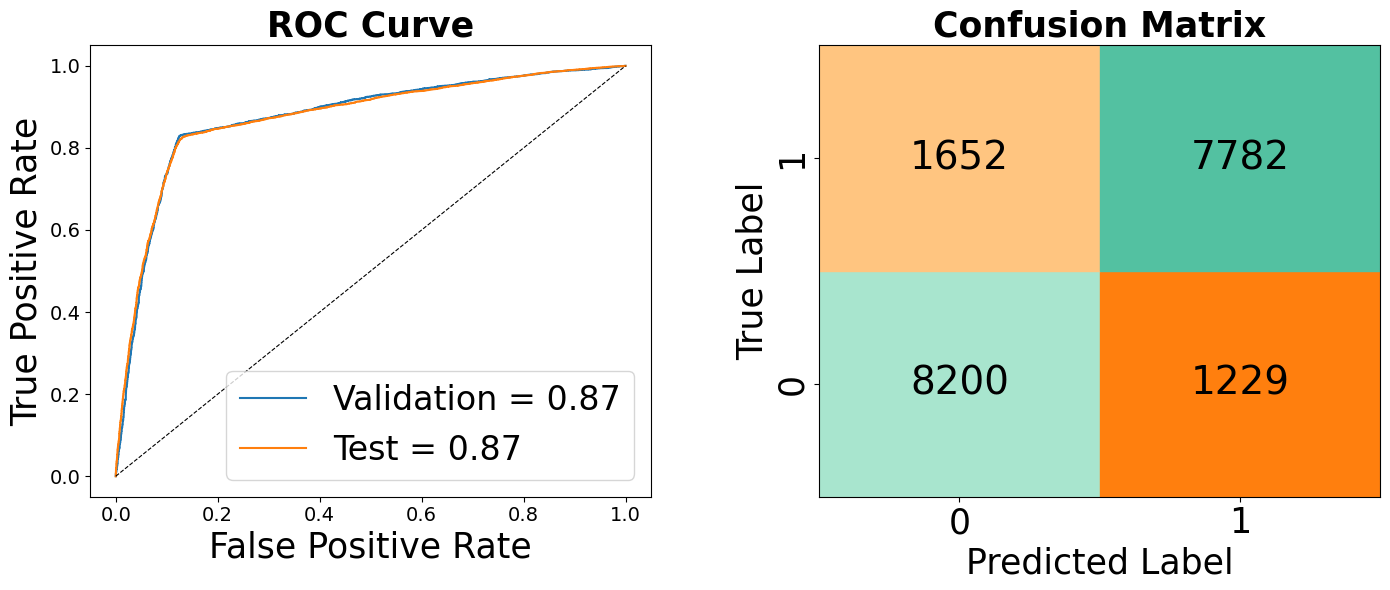


Validation Metrics:
Accuracy: 0.85, Precision: 0.87, Recall: 0.83, F1: 0.85, AUC: 0.87

Test Metrics:
Accuracy: 0.85, Precision: 0.86, Recall: 0.82, F1: 0.84, AUC: 0.87


In [26]:
# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

#  Enhanced Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100],        # Number of trees
    'max_depth': [None],               # Depth of the trees
    'min_samples_split': [10],           # Minimum samples to split a node
    'min_samples_leaf': [2],             # Minimum samples at a leaf node
    'criterion': ['entropy'],          # Splitting criteria
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best Random Forest model
best_rf = grid_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

# Evaluate on the Test Set
y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve for Validation and Test Sets
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


#### 7-4 XGboost

Best Hyperparameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


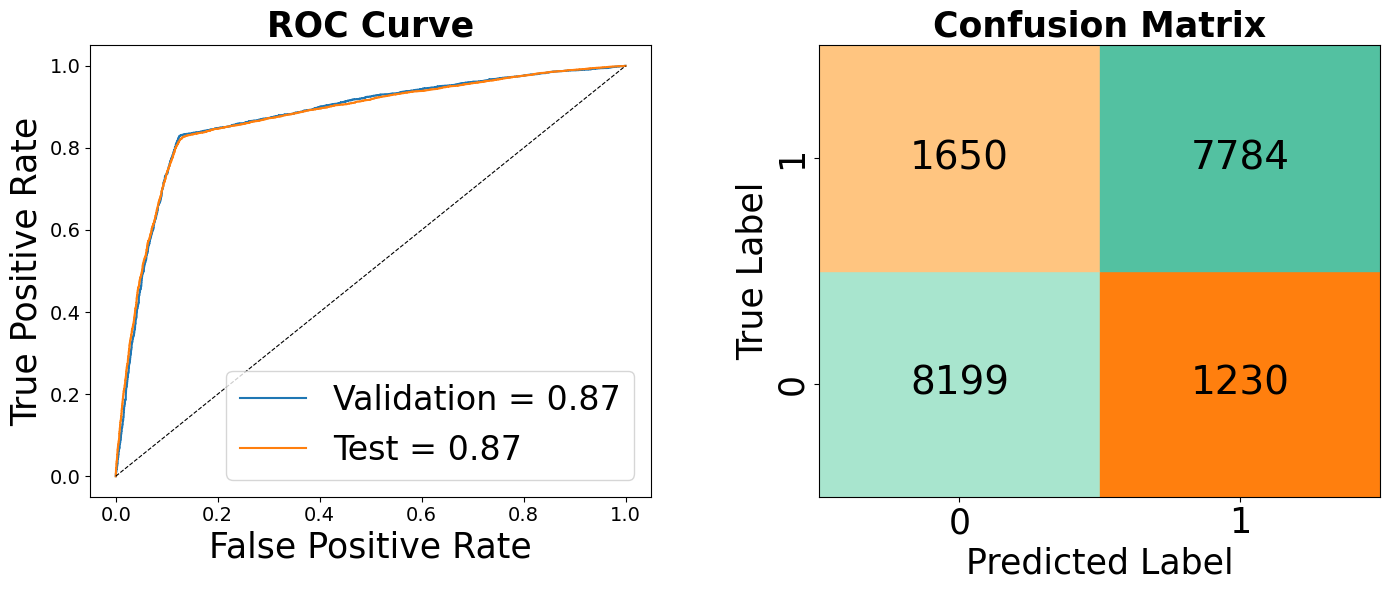


Validation Metrics:
Accuracy: 0.85, Precision: 0.87, Recall: 0.83, F1: 0.85, AUC: 0.87

Test Metrics:
Accuracy: 0.85, Precision: 0.86, Recall: 0.82, F1: 0.84, AUC: 0.87


In [27]:
# Initialize the XGBoost model
xgb_param_grid = {
    'n_estimators': [200],       # Number of trees
    'max_depth': [5],                  # Maximum depth of a tree
    'learning_rate': [0.01],   # Boosting learning rate
}

xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_
print("Best Hyperparameters for XGBoost:", best_params)

# Metrics on Validation Set
y_val_pred_xgb = best_xgb.predict(X_val)
y_val_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
val_precision_xgb = precision_score(y_val, y_val_pred_xgb)
val_recall_xgb = recall_score(y_val, y_val_pred_xgb)
val_f1_xgb = f1_score(y_val, y_val_pred_xgb)
val_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)

# Metrics on Test Set
y_test_pred_xgb = best_xgb.predict(X_test)
y_test_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb)
test_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred_xgb)

# ROC Curve
val_fpr_xgb, val_tpr_xgb, _ = roc_curve(y_val, y_val_proba_xgb)
test_fpr_xgb, test_tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


### 7-5 Multi Layer Perceptron

Best Hyperparameters: {'batch_size': 64, 'epochs': 15, 'model__activation': 'tanh', 'model__dropout_rate': 0, 'model__hidden_layers': (16, 32, 16), 'model__learning_rate': 0.001}


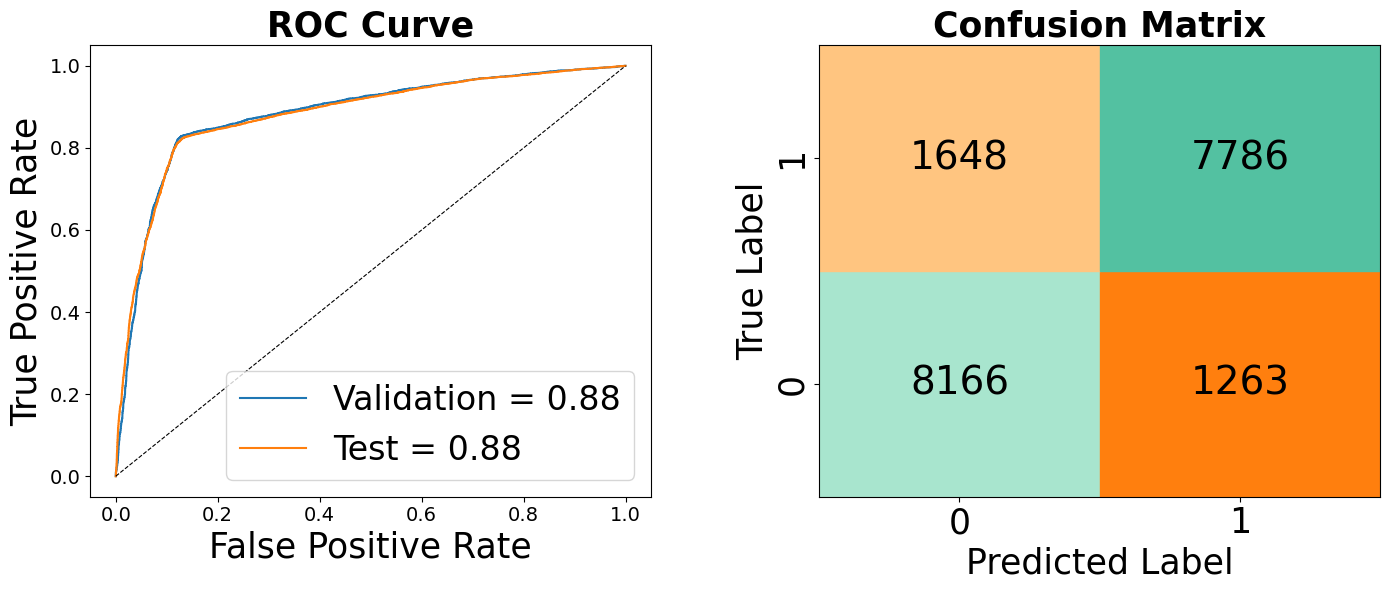


Validation Metrics:
Accuracy: 0.85, Precision: 0.87, Recall: 0.83, F1: 0.85, AUC: 0.88

Test Metrics:
Accuracy: 0.85, Precision: 0.86, Recall: 0.83, F1: 0.84, AUC: 0.88


In [28]:
# Define the MLP model
def create_mlp(hidden_layers=(32,), activation='relu', learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation=activation, input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model using scikeras' KerasClassifier
mlp = KerasClassifier(model=create_mlp, verbose=0)


# Hyperparameter tuning grid
param_grid = {
    "model__hidden_layers": [(16,32,16)],  
    "model__learning_rate": [0.001],
    "model__dropout_rate": [0],
    "model__activation": ['tanh'],
    "batch_size": [64],
    "epochs": [15]
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best MLP model
best_mlp = grid_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_mlp.predict(X_val)
y_val_proba = best_mlp.predict_proba(X_val)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

# Evaluate on the Test Set
y_test_pred = best_mlp.predict(X_test)
y_test_proba = best_mlp.predict_proba(X_test)[:, 1]

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve for Validation and Test Sets
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


### 7-6 RNN

Best Hyperparameters: {'batch_size': 32, 'epochs': 15, 'model__activation': 'tanh', 'model__dropout_rate': 0, 'model__hidden_units': 32, 'model__learning_rate': 0.001, 'model__optimizer': 'adam'}


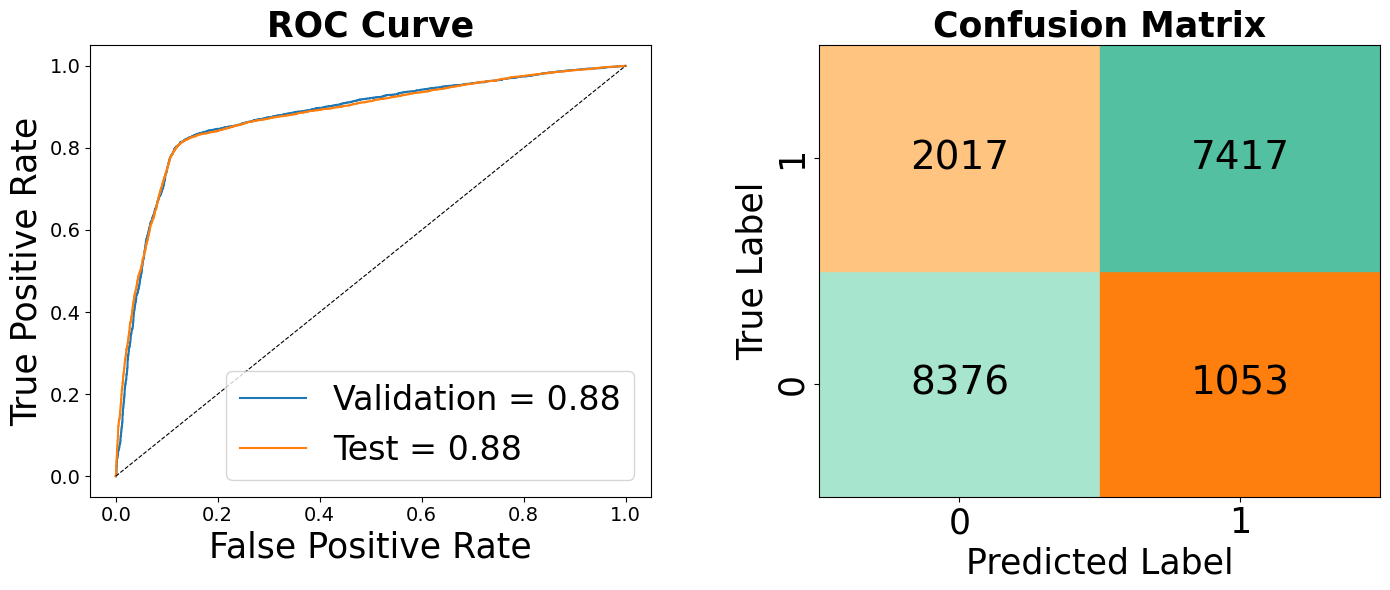


Validation Metrics:
Accuracy: 0.84, Precision: 0.88, Recall: 0.78, F1: 0.83, AUC: 0.88

Test Metrics:
Accuracy: 0.84, Precision: 0.88, Recall: 0.79, F1: 0.83, AUC: 0.88


In [29]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Define the RNN model
def create_rnn(hidden_units=32, activation='tanh', learning_rate=0.001, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Select optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model using scikeras' KerasClassifier
rnn = KerasClassifier(model=create_rnn, verbose=0)

# Hyperparameter tuning grid
param_grid = {
    "model__hidden_units": [32],
    "model__activation": ['tanh'],
    "model__learning_rate": [0.001],
    "model__dropout_rate": [0],
    "batch_size": [32],
    "epochs": [15],
    "model__optimizer": ['adam'], 

}

grid_search = GridSearchCV(estimator=rnn, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best RNN model
best_rnn = grid_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_rnn.predict(X_val)
y_val_proba = best_rnn.predict_proba(X_val)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

# Evaluate on the Test Set
y_test_pred = best_rnn.predict(X_test)
y_test_proba = best_rnn.predict_proba(X_test)[:, 1]

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve for Validation and Test Sets
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


### 7-7 Tabnet


epoch 0  | loss: 0.4443  | val_auc: 0.87322 |  0:00:05s
epoch 1  | loss: 0.42106 | val_auc: 0.87652 |  0:00:11s
epoch 2  | loss: 0.41615 | val_auc: 0.87847 |  0:00:17s
epoch 3  | loss: 0.41499 | val_auc: 0.87923 |  0:00:23s
epoch 4  | loss: 0.41443 | val_auc: 0.87836 |  0:00:29s
epoch 5  | loss: 0.41408 | val_auc: 0.88038 |  0:00:35s
epoch 6  | loss: 0.41506 | val_auc: 0.87894 |  0:00:41s
epoch 7  | loss: 0.4146  | val_auc: 0.88031 |  0:00:46s
epoch 8  | loss: 0.41287 | val_auc: 0.87969 |  0:00:52s
epoch 9  | loss: 0.41257 | val_auc: 0.88002 |  0:00:58s
epoch 10 | loss: 0.41274 | val_auc: 0.88116 |  0:01:04s
epoch 11 | loss: 0.41252 | val_auc: 0.88079 |  0:01:10s
epoch 12 | loss: 0.41302 | val_auc: 0.88036 |  0:01:16s
epoch 13 | loss: 0.41205 | val_auc: 0.88116 |  0:01:22s
epoch 14 | loss: 0.41134 | val_auc: 0.88115 |  0:01:28s
epoch 15 | loss: 0.412   | val_auc: 0.88063 |  0:01:34s
epoch 16 | loss: 0.41234 | val_auc: 0.88119 |  0:01:40s
epoch 17 | loss: 0.41269 | val_auc: 0.88035 |  0

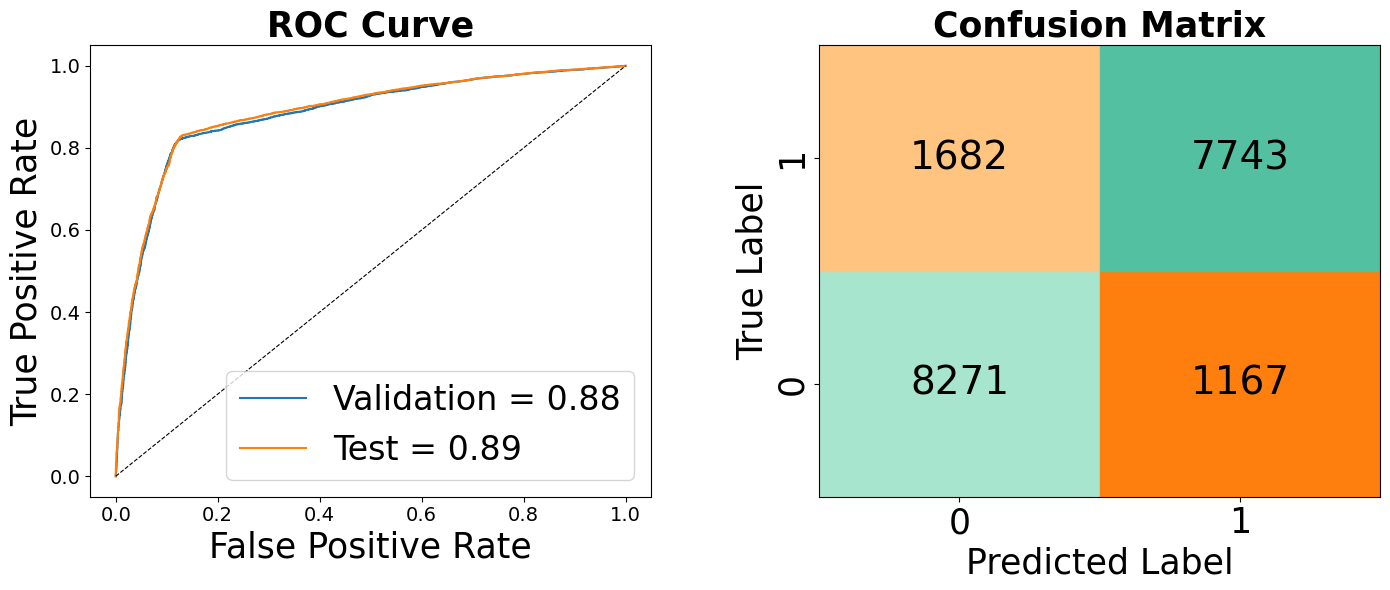


Validation Metrics:
Accuracy: 0.85, Precision: 0.87, Recall: 0.81, F1: 0.84, AUC: 0.88

Test Metrics:
Accuracy: 0.85, Precision: 0.87, Recall: 0.82, F1: 0.84, AUC: 0.89


In [30]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the TabNet wrapper class
class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=1e-3):
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse
        self.model = None

    def fit(self, X, y):
        # Convert pandas DataFrame/Series to NumPy arrays
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y
        
        self.model = TabNetClassifier(
            n_d=self.n_d, n_a=self.n_a, n_steps=self.n_steps, gamma=self.gamma,
            lambda_sparse=self.lambda_sparse, optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=0.02), mask_type="entmax"
        )
        self.model.fit(
            X_train=X, y_train=y,
            eval_set=[(X_val.values, y_val.values)],
            eval_name=["val"],
            eval_metric=["auc"],
            max_epochs=50,
            patience=10,
            batch_size=256, virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )
        return self

    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        return self.model.predict(X)

    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return {
            "n_d": self.n_d,
            "n_a": self.n_a,
            "n_steps": self.n_steps,
            "gamma": self.gamma,
            "lambda_sparse": self.lambda_sparse,
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Define hyperparameter grid
param_grid = {
    "n_d": [8],
    "n_a": [8],
    "n_steps": [3],
    "gamma": [1.0],
}

# Use GridSearchCV
grid_search = GridSearchCV(estimator=TabNetWrapper(), param_grid=param_grid, scoring="f1", cv=3, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best TabNet model
best_tabnet = grid_search.best_estimator_

# Evaluate on the Validation Set
y_val_pred = best_tabnet.predict(X_val)
y_val_proba = best_tabnet.predict_proba(X_val)[:, 1]

# Validation Metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

# Evaluate on the Test Set
y_test_pred = best_tabnet.predict(X_test)
y_test_proba = best_tabnet.predict_proba(X_test)[:, 1]

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve for Validation and Test Sets
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

# Create Subplots for ROC Curve and Confusion Matrix
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
axs[0].plot(val_fpr, val_tpr, label=f"Validation = {val_auc:.2f}")
axs[0].plot(test_fpr, test_tpr, label=f"Test = {test_auc:.2f}")
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.8)
axs[0].set_title("ROC Curve", fontsize=25, fontweight='bold')
axs[0].set_xlabel("False Positive Rate", fontsize=25)
axs[0].set_ylabel("True Positive Rate", fontsize=25)
# axs[0].legend()
axs[0].legend(
    loc='lower right',                 # Change position
    bbox_to_anchor=(1.0, 0.0),         # Fine-tune position relative to the axes
    prop={'size': 24}
)
axs[0].tick_params(axis='both', labelsize=14)


# Plot Confusion Matrix with Custom Colors
# Define custom colors for TP, TN, FP, and FN
colors = {
    'TP': '#53c1a1',  # Green for True Positives
    'TN': '#a8e5ce',  # Light Green for True Negatives
    'FP': '#ff7f0e',  # Orange for False Positives
    'FN': '#ffc580'   # Light Orange for False Negatives
}

# Plot each cell of the confusion matrix with appropriate colors
n_rows, n_cols = conf_matrix.shape
for i in range(n_rows):
    for j in range(n_cols):
        value = conf_matrix[i, j]
        # Assign colors based on the cell meaning
        if i == j:  # Diagonal cells (TP, TN)
            color = colors['TP'] if i == 1 else colors['TN']
        else:  # Off-diagonal cells (FP, FN)
            color = colors['FP'] if j == 1 else colors['FN']
        # Draw the rectangle with the assigned color
        axs[1].add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Add text in the center of the cell
        text_color = 'black' if value > conf_matrix.max() / 2 else 'black'
        axs[1].text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=text_color, fontsize=28)

# Configure Confusion Matrix axis labels and ticks
axs[1].set_xticks(np.arange(n_cols) + 0.5)
axs[1].set_yticks(np.arange(n_rows) + 0.5)
axs[1].set_xticklabels(['0', '1'], fontsize=25)
axs[1].set_yticklabels(['0', '1'], fontsize=25, rotation=90, verticalalignment='center')
axs[1].set_xlabel('Predicted Label', fontsize=25)
axs[1].set_ylabel('True Label', fontsize=25)

# Add title for Confusion Matrix
axs[1].set_title('Confusion Matrix', fontsize=25, fontweight='bold')
axs[1].set_xlim(0, n_cols)
axs[1].set_ylim(0, n_rows)
axs[1].grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print Metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}, AUC: {val_auc:.2f}")
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}, AUC: {test_auc:.2f}")


# 8- Reporting the Results
#### We can use a bar plot to comapre the performance across 7 classifiers and report the results:

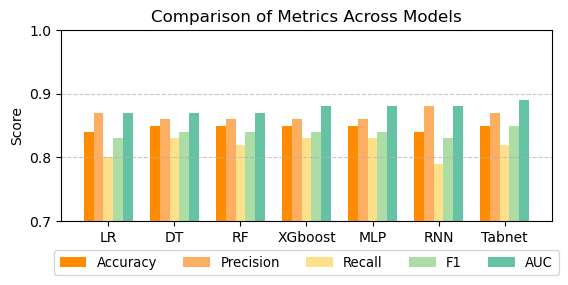

In [35]:
# Data
models = ['LR', 'DT', 'RF', 'XGboost', 'MLP', 'RNN', 'Tabnet']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
data = [
    [0.84, 0.87, 0.80, 0.83, 0.87],  # LR
    [0.85, 0.86, 0.83, 0.84, 0.87],  # DT
    [0.85, 0.86, 0.82, 0.84, 0.87],  # RF
    [0.85, 0.86, 0.83, 0.84, 0.88],  # XGboost
    [0.85, 0.86, 0.83, 0.84, 0.88],  # MLP
    [0.84, 0.88, 0.79, 0.83, 0.88],  # RNN
    [0.85, 0.87, 0.82, 0.85, 0.89],  # Tabnet
]

# Convert data into a NumPy array for easier plotting
data = np.array(data)

# Bar chart parameters
x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

# Define a gradient color palette between green and orange
gradient_colors = ['#FF8C00', '#fdae61', '#fee08b', '#abdda4', '#66c2a5']

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Plot each metric with the gradient colors
for i, (metric, color) in enumerate(zip(metrics, gradient_colors)):
    ax.bar(x + i * width, data[:, i], width, label=metric, color=color)

# Add labels, title, and legend
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Models')
ax.set_xticks(x + width * 2)  # Adjust to align with groups
ax.set_xticklabels(models)
ax.set_ylim(0.7, 1)  # Adjust Y-axis to focus on the range

# Move the legend to a single row below the graph
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),  # Position below the plot
    ncol=len(metrics),  # One row with all metrics
    fontsize=9.5
)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


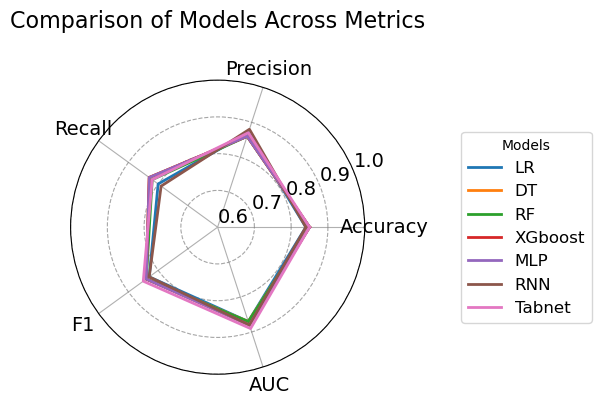

In [36]:
from math import pi
import matplotlib.pyplot as plt

# Data
models = ['LR', 'DT', 'RF', 'XGboost', 'MLP', 'RNN', 'Tabnet']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
data = [
    [0.84, 0.87, 0.80, 0.83, 0.87],  # LR
    [0.85, 0.86, 0.83, 0.84, 0.87],  # DT
    [0.85, 0.86, 0.82, 0.84, 0.87],  # RF
    [0.85, 0.86, 0.83, 0.84, 0.88],  # XGboost
    [0.85, 0.86, 0.83, 0.84, 0.88],  # MLP
    [0.84, 0.88, 0.79, 0.83, 0.88],  # RNN
    [0.85, 0.87, 0.82, 0.85, 0.89],  # Tabnet
]

# Radar chart setup
num_vars = len(metrics)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Close the radar chart loop

# Plot all models on the same radar chart
plt.figure(figsize=(6, 6))  # Adjust figure size
ax = plt.subplot(111, polar=True)

# Add metric labels as angles
plt.xticks(angles[:-1], metrics, fontsize=14)

# Add each model as an outline
for i, model in enumerate(models):
    values = data[i] + data[i][:1]  # Close the loop for each model
    ax.plot(angles, values, linewidth=2, label=model)  # Outline only (no fill)

# Customize radial gridlines
ax.set_ylim(0.6, 1.0)
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax.yaxis.grid(True, color='gray', linestyle='--', alpha=0.7)
ax.tick_params(axis='y', labelsize=14)  # Increase font size for radial tick numbers

# Add legend to the right middle of the plot
plt.legend(
    loc="center left",  # Place the legend at the center left relative to the plot
    bbox_to_anchor=(1.3, 0.5),  # Adjust position to the right middle
    fontsize=12,  # Adjust font size
    title="Models"
)

# Add title
plt.title("Comparison of Models Across Metrics", size=16, y=1.15 )

plt.tight_layout()
plt.show()

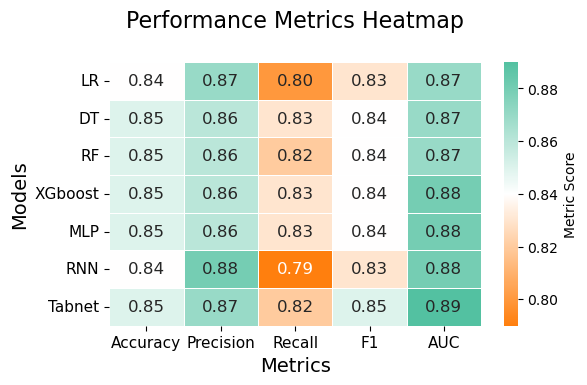

In [39]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame for heatmap
df_heatmap = pd.DataFrame(data, columns=metrics, index=models)

# Custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#ff7f0e', 'white', '#53c1a1'])

# Heatmap with increased annotation font size
plt.figure(figsize=(6, 4))
sns.heatmap(
    df_heatmap,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=0.5,
    cbar_kws={'label': 'Metric Score'},
    annot_kws={"fontsize": 12}  # Simplified font size adjustment
)
plt.title("Performance Metrics Heatmap", fontsize=16,  y=1.10)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Models", fontsize=14, )
plt.yticks(rotation=0,  fontsize=11)
plt.xticks( fontsize=11)

plt.tight_layout()
plt.show()


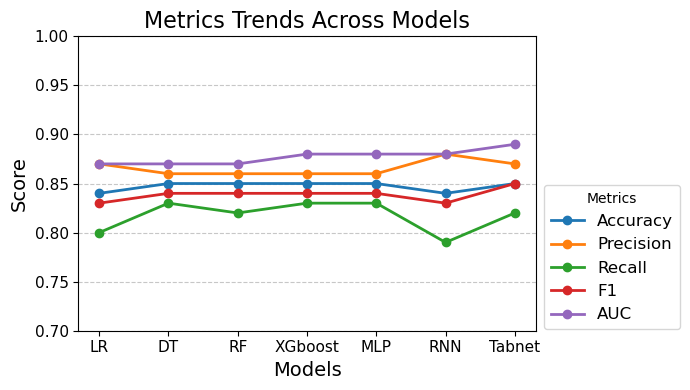

In [40]:
# Line Plot
plt.figure(figsize=(7, 4))

# Plot each metric as a separate line
for metric in metrics:
    plt.plot(models, df_heatmap[metric], marker="o", label=metric, linewidth=2)

# Add labels, title, and legend
plt.title("Metrics Trends Across Models", fontsize=16, y=1.0)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0.7, 1.0)  # Set y-axis starting from 0.8
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Adjust legend to appear outside the chart
plt.legend(title="Metrics", fontsize=12, loc='center left', bbox_to_anchor=(1, 0.25), ncol=1)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure everything fits well
plt.tight_layout()
plt.show()


# 10- Feature Importance and Model Explanation

epoch 0  | loss: 0.50702 | val_0_f1_score: 0.81621 |  0:00:03s
epoch 1  | loss: 0.42797 | val_0_f1_score: 0.82777 |  0:00:07s
epoch 2  | loss: 0.42274 | val_0_f1_score: 0.83625 |  0:00:10s
epoch 3  | loss: 0.41872 | val_0_f1_score: 0.84173 |  0:00:14s
epoch 4  | loss: 0.41793 | val_0_f1_score: 0.84515 |  0:00:18s
epoch 5  | loss: 0.4174  | val_0_f1_score: 0.84323 |  0:00:21s
epoch 6  | loss: 0.41606 | val_0_f1_score: 0.84654 |  0:00:25s
epoch 7  | loss: 0.41521 | val_0_f1_score: 0.84673 |  0:00:29s
epoch 8  | loss: 0.41531 | val_0_f1_score: 0.84629 |  0:00:33s
epoch 9  | loss: 0.41376 | val_0_f1_score: 0.84686 |  0:00:37s
epoch 10 | loss: 0.4151  | val_0_f1_score: 0.84557 |  0:00:41s
epoch 11 | loss: 0.41632 | val_0_f1_score: 0.84657 |  0:00:45s
epoch 12 | loss: 0.41339 | val_0_f1_score: 0.84642 |  0:00:49s
epoch 13 | loss: 0.41316 | val_0_f1_score: 0.84697 |  0:00:53s
epoch 14 | loss: 0.41208 | val_0_f1_score: 0.84684 |  0:00:56s
epoch 15 | loss: 0.41128 | val_0_f1_score: 0.8457  |  0

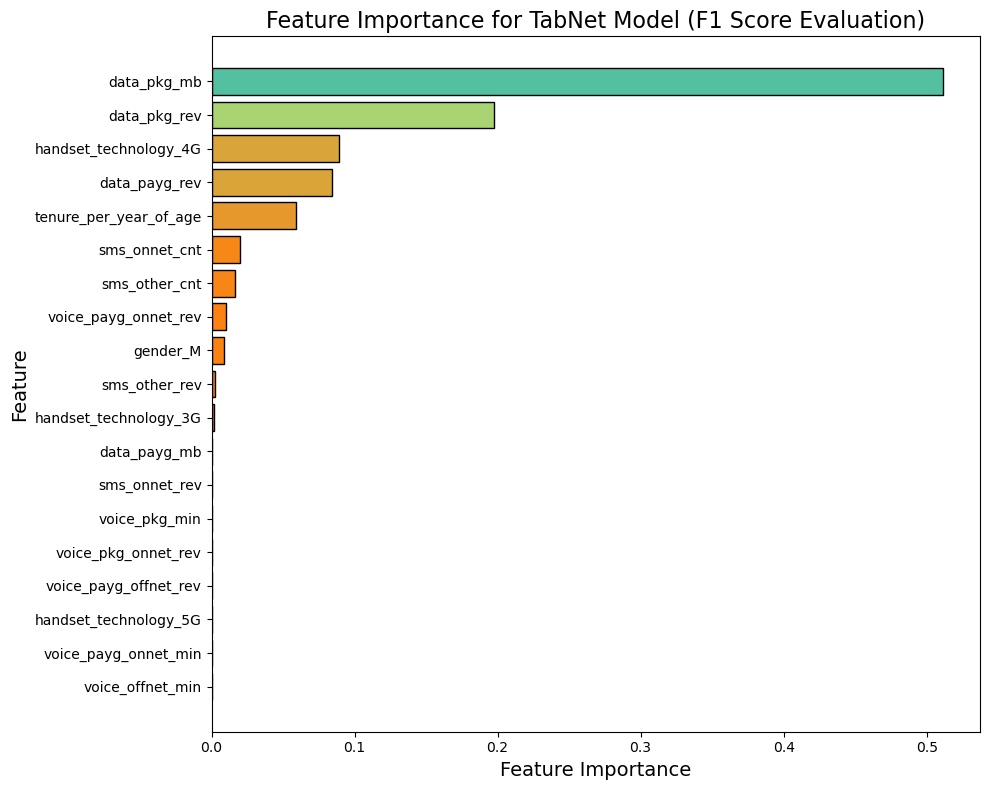

Best Epoch: 29
Best Validation F1 Score: 0.8473459597471571


In [25]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

feature_names = [
    "voice_payg_onnet_rev", "voice_pkg_onnet_rev", "voice_payg_offnet_rev",
    "data_pkg_rev", "data_payg_rev", "sms_onnet_rev", "sms_other_rev",
    "voice_payg_onnet_min", "voice_pkg_min", "voice_offnet_min",
    "data_pkg_mb", "data_payg_mb", "sms_onnet_cnt", "sms_other_cnt",
    "tenure_per_year_of_age", "gender_M", 
    "handset_technology_3G", "handset_technology_4G", "handset_technology_5G"
]

# Convert Pandas DataFrame/Series to NumPy arrays if needed
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val

# Define Custom F1 Metric
class F1Metric(Metric):
    def __init__(self):
        self._name = "f1_score"
        self._maximize = True  # Higher F1 score is better

    def __call__(self, y_true, y_pred):
        preds = np.argmax(y_pred, axis=1)  # Get predicted class labels
        return f1_score(y_true, preds, average="weighted")  # Weighted F1 Score

# Train the TabNet Model with Best Hyperparameters
tabnet_model = TabNetClassifier(
    gamma=1.0,       # Hyperparameter from the best model
    n_a=8,           # Hyperparameter from the best model
    n_d=8,           # Hyperparameter from the best model
    n_steps=3,       # Hyperparameter from the best model
    seed=42,
    verbose=1
)

# Fit the model
tabnet_model.fit(
    X_train_np, y_train_np,                # Use NumPy arrays for training
    eval_set=[(X_val_np, y_val_np)],       # Use NumPy arrays for validation
    eval_metric=[F1Metric],  # Using F1 score as evaluation metric
    patience=10,      # Early stopping patience
    max_epochs=50     # Cap on maximum epochs
)

#  Extract Feature Importance from the TabNet Model
tabnet_feature_importances = tabnet_model.feature_importances_

# Sort the feature importances and feature names
sorted_indices = np.argsort(tabnet_feature_importances)
sorted_feature_importances = tabnet_feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]  # Assuming `feature_names` is already defined

# Create Gradient Color Map
cmap = LinearSegmentedColormap.from_list("custom_gradient", ['#ff7f0e', 'lightgreen', '#53c1a1'])
norm = plt.Normalize(vmin=min(sorted_feature_importances), vmax=max(sorted_feature_importances))
colors = [cmap(norm(value)) for value in sorted_feature_importances]

# Plot Horizontal Bar Chart for Feature Importance
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, color=colors, edgecolor="black")
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Feature Importance for TabNet Model (F1 Score Evaluation)", fontsize=16)
plt.tight_layout()
plt.show()

# Print Important Metrics
print(f"Best Epoch: {tabnet_model.best_epoch}")
print(f"Best Validation F1 Score: {tabnet_model.best_cost}")
